# Actividad pr√°ctica: Predicci√≥n de series de tiempo

En esta tarea se pide entrenar y evaluar un predictor para la serie de tiempo Mackey-Glass. Esta serie de tiempo se obtiene de la soluci√≥n de la siguiente ecuaci√≥n diferencial

$$
\frac{dy}{dt} = 0.2 \frac{ y(t-\tau)}{1 + y(t-\tau)^{10}} - 0.1 y(t),
$$

donde el par√°metro $\tau$ controla el comportamiento din√°mico de la serie de tiempo 

- Siga las instrucciones en este notebook para resolver el problema de predicci√≥n
- Conteste las preguntas que se encuentran en este enunciado
- Finalmente env√≠e su notebook con los resultados y respuestas a phuijse@inf.uach.cl
- No olvide cambiar el t√≠tulo para reflejar los integrantes de su grupo

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pylab as plt
import pandas as pd

NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)

***

Use el c√≥digo que se muestra a continuaci√≥n para generar la serie de tiempo Mackey Glass

- Considere una raz√≥n se√±al a ruido (SNR) de 2.
- Considere $\tau=17$ (comportamiento debilmente ca√≥tico)

Se generaran 1000 muestras de la serie de tiempo. Use los primeros 500 puntos para entrenar y los siguientes 500 puntos para hacer predicci√≥n

<IPython.core.display.Javascript object>


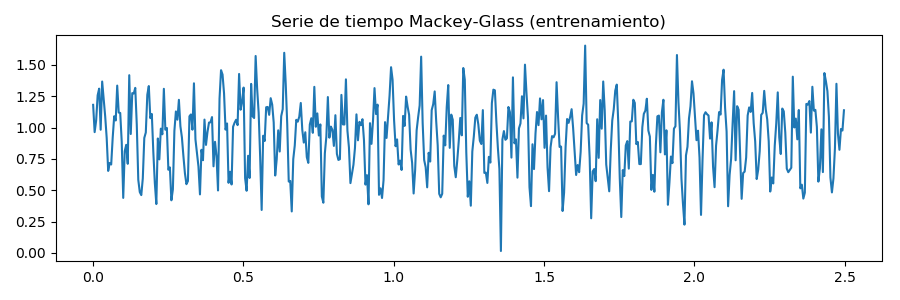

In [2]:
# n√∫mero de observaciones (no modificar)
N = 1000
# Raz√≥n se√±al a ruido (2., 0.5)
SNR = 2.
# constantes de la ecuaci√≥n diferencial (no modificar)
a, b = 0.1, 0.2
# comportamiento din√°mico de Mackey-Glass (17, 30)
tau = 17.
# paso de integraci√≥n (no modificar)
dt = 0.05
# condici√≥n incial (no modificar)
y0 = 0.9
# largo temporal (no modificar)
tt = 5.
t = np.linspace(0, tt, num=N)

N_full, tau_full = int(N*tt/dt), int(tau/dt)
ymg = y0*np.ones(shape=(N_full, ))
# Runge-Kutta integration
for n in range(tau_full, N_full-1):
    byd = b*ymg[n-tau_full]/(1.0 + ymg[n-tau_full]**10.0)
    yk1 = dt*(-a*ymg[n] + byd)
    yk2 = dt*(-a*(ymg[n]+yk1/2) + byd)
    yk3 = dt*(-a*(ymg[n]+yk2/2) + byd)
    yk4 = dt*(-a*(ymg[n]+yk3) + byd)
    ymg[n+1] = ymg[n] + yk1/6 + yk2/3 +yk3/3 +yk4/6;
ymg = ymg[::int(tt/dt)]
#ymg = ymg - np.mean(ymg) 
# Contaminaci√≥n con ruido blanco aditivo
s_noise = np.sqrt(np.var(ymg)/SNR) 
np.random.seed(0)
y_obs = ymg + s_noise*np.random.randn(len(ymg))
# Gr√°fico
fig, ax = plt.subplots(1, figsize=(9, 3), tight_layout=True)
ax.plot(t[:500], y_obs[:500])
ax.set_title('Serie de tiempo Mackey-Glass (entrenamiento)');

***

1. Describa en detalle el algoritmo LMS indicando sus semejanzas y diferencias con el filtro de Wiener 
1. Partiendo del error instantaneo $J_n^s(\textbf{w}) = e_n^2$ derive la regla de actualizaci√≥n de pesos
1. La siguiente clase de *Python* predice y entrena un filtro LMS. Complete la l√≠nea que dice 

` self.w = ? `

con el valor correcto de actualizaci√≥n de peso del filtro LMS

## Respuestas

### 1.
### El filtro de Wiener b√°sico consistir√≠a en obtener los coeficientes de un sistema LTI despu√©s de un paso previo deterministico de "entrenamiento" del cual si el sistema LTI obtenido se convoluciona con la se√±al dise√±ada debe ser capaz de cumplir su objetivo de filtrado.
### A diferencia del algoritmo de LMS que consiste en la obtenci√≥n de un sistema adaptativo tal que actualiza recursivamente sus pesos con su matriz de correlaci√≥n instantanea.
### La principal semejanza es el de la funci√≥n final de ambos algoritmos de filtro si se les entrena igual, pero la diferencia principal es que Wiener considerando la muestra de entrenamiento dada, √©sta ser√≠a optima, mientras que LMS no lo ser√≠a (aunque tender√≠a a serlo) pero al ser capaz de ser modificada a medida en tiempo real sin necesidad de repetir todo el algoritmo con la nueva informaci√≥n, se obtiene una optimizaci√≥n del lado del rendimiento muy considerable.

### 2.
$$
\begin{align}
\textbf{w}_{n+1} &= \textbf{w}_{n} + 2 \mu e¬≤_n \textbf{u}_{n}\nonumber \\
\end{align}
$$

### 3.


$$
\begin{align}
\textbf{w}_{n+1} &= \textbf{w}_{n} + 2 \mu (d_n -  \textbf{w}_{n}^T \textbf{u}_{n}) \textbf{u}_{n}, \nonumber 
\end{align}
$$

In [3]:
class LMS_filter(object):
    
    def __init__(self, L=1, mu=0.5, normalized=True):
        self.L = L
        self.mu = mu
        self.w = np.zeros(shape=(L, ))
        self.normalized = normalized
    
    def __len__(self):
        return self.L
    
    def predict(self, u):
        return np.dot(self.w, u)
    
    def update(self, u, d):
        ## d es la se√±al deseada
        ## u es la se√±al obtenida con ruido
        d_pred = self.predict(u)
        norm = 1.
        if self.normalized:
            norm = np.sum(u**2) + 1e-6
        self.w = self.w + 2*self.mu*(d - d_pred)*u/norm

***
## Predicci√≥n con algoritmo LMS

1. Entrene el predictor con el algoritmo normalized LMS usando el siguiente bloque de c√≥digo
1. Construya una tabla con los NMSE de entrenamiento y prueba para distintos valores de $\mu$ y $L$
    - Se recomienda hacer un barrido logar√≠tmico en $\mu$ (por ejemplo `mu=np.logspace(-2, 0, num=20)`)
    - Use al menos los siguientes valores de $L$: [5, 10, 20, 30]
1. Describa cada experimento analizando sus resultados de forma cuantitativa y cualitativa
    - ¬øSe sobreajusta el filtro a los datos de entrenamiento? 
    - ¬øSe desestabiliza el filtro?
1. Indique que combinaci√≥n obtiene menor MSE de prueba 
***

1. Repita el experimento para $\tau = 30$ (comportamiento fuertemente ca√≥tico) 
1. Compare los resultados obtenidos con cada serie de tiempo. ¬øQu√© casos son m√°s sencillos y cuales m√°s complicados?


## 1.

In [4]:
mu = np.logspace(-2, 0, num=20)
#print(mu)
L = [5, 10, 20, 30]

tabla = np.zeros((len(mu), len(L)*2))
#print(tabla)
experimentos = {
    "optimo": [],
    "media": [],
    "inestable": []
}

optimo_mu = -1
optimo_l = -1
optimo_num = 9999999

cont_mu = 0
for i in mu:
    cont_columna = 0
    
    cont_l = 0
    for j in L:
        lms = LMS_filter(L=j, mu=i, normalized=True)
        # Entrenamiento
        y_pred = np.zeros(shape=(len(y_obs), ))
        for k in range(lms.__len__(), 500):
            y_window = y_obs[k-lms.__len__():k]
            y_pred[k] = lms.predict(y_window)
            lms.update(d=y_obs[k], u=y_window)
        # Prueba
        for k in range(500, len(y_obs)):
            y_window = y_obs[k-lms.__len__():k]
            y_pred[k] = lms.predict(y_window)
        ## Optimo
        if (cont_mu == 9 and cont_l == 3):
            experimentos["optimo"] = y_pred
        elif (cont_mu == 19 and cont_l == 0): ## Inestable
            experimentos["inestable"] = y_pred
        elif (cont_mu == 14 and cont_l == 1): ## Media
            experimentos["media"] = y_pred
            
            
        entrenamiento = NMSE(ymg[lms.__len__():500], y_pred[lms.__len__():500])
        prueba = NMSE(ymg[500:], y_pred[500:])
        if (prueba < optimo_num):
            optimo_mu = cont_mu
            optimo_l = cont_l
            optimo_num = prueba
        tabla[cont_mu][cont_columna] = np.format_float_scientific(entrenamiento, 7)
        tabla[cont_mu][cont_columna+1] = np.format_float_scientific(prueba, 7)
        #print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[lms.__len__():500], y_pred[lms.__len__():500]), 
        #                                                NMSE(ymg[500:], y_pred[500:])))
        cont_l += 1
        cont_columna += 2
    cont_mu += 1

print("El mu optimo es: " + str(mu[optimo_mu]) + ", junto con el L optimo: " + str(L[optimo_l]) + ", con MSE de prueba: " + str(optimo_num))
print("El mu peor es: " + str(mu[19]) + ", junto con el L peor: " + str(L[0]) + ", con MSE de prueba: " + str(tabla[19][1]))
print("El mu media es: " + str(mu[14]) + ", junto con el L media: " + str(L[1]) + ", con MSE de prueba: " + str(tabla[14][3]))

El mu optimo es: 0.08858667904100823, junto con el L optimo: 30, con MSE de prueba: 187.9156101628255
El mu peor es: 1.0, junto con el L peor: 5, con MSE de prueba: 94442.719
El mu media es: 0.29763514416313175, junto con el L media: 10, con MSE de prueba: 431.73311


## 2.

In [5]:
pd.DataFrame(tabla, columns=["5_entrenamiento","5_prueba", "10_entrenamiento", "10_prueba", "20_entrenamiento", "20_prueba", "30_entrenamiento", "30_prueba"])

5_entrenamiento     5_prueba  10_entrenamiento     10_prueba  \
0        1227.87540    772.85941         912.09905     423.23028   
1        1136.92040    737.47381         804.23052     397.23155   
2        1058.87280    699.63728         713.67271     369.69370   
3         990.57804    660.83720         635.91783     342.03376   
4         930.76345    622.75824         568.64921     316.11199   
5         879.28133    587.18040         511.08679     293.96684   
6         836.28797    555.90646         463.09653     277.33841   
7         801.89546    530.89060         424.52261     267.08655   
8         776.41860    514.48872         394.95418     262.80051   
9         760.87224    509.46698         373.83567     263.09126   
10        757.27888    518.47173         360.74840     266.95407   
11        768.60705    543.27319         355.71219     275.86316   
12        798.57131    584.66049         359.35494     295.69284   
13        851.90817    645.37964         372.95413     339.09695   
14        936.24328    748.34829         398.72987     431.73311   
15       1068.21670   1006.64490         441.24610     624.34517   
16       1291.63540   1772.73610         512.33466    1007.39510   
17       1738.86460   3777.32720         649.90714    1808.11680   
18       3023.39590   8874.57270        1032.44270    5186.23620   
19     123371.81000  94442.71900       46336.22100  249576.52000   

    20_entrenamiento   20_prueba  30_entrenamiento    30_prueba  
0          902.90376   384.04883         886.42052    393.91738  
1          794.98792   356.40785         780.53695    367.70992  
2          704.57338   326.18650         692.56055    338.82778  
3          626.49684   294.54077         616.85319    308.24675  
4          557.82102   263.24086         549.89654    277.45550  
5          497.42285   234.60747         490.10847    248.36634  
6          445.22306   211.29791         437.24531    223.11385  
7          401.43655   195.90006         391.66776    203.76819  
8          366.09977   190.28607         353.75686    191.89525  
9          338.87636   194.81113         323.58430    187.91561  
10         319.07171   207.82017         300.82722    190.61096  
11         305.85401   226.24449         284.90813    197.54933  
12         298.65071   247.71246         275.29975    206.79464  
13         297.57945   273.61276         271.91241    219.07240  
14         303.76873   311.99167         275.61181    239.26609  
15         319.59604   380.10407         289.03500    277.78013  
16         349.60344   506.63620         318.12173    353.58180  
17         406.02310   735.34364         377.19472    502.99525  
18         546.01051  1184.10270         522.92120    807.07088  
19        6312.37030  3061.58540        5885.70280  23877.50100

## 3.

## La prueba optima con ùúá‚âà0.0886 y L=30

<IPython.core.display.Javascript object>


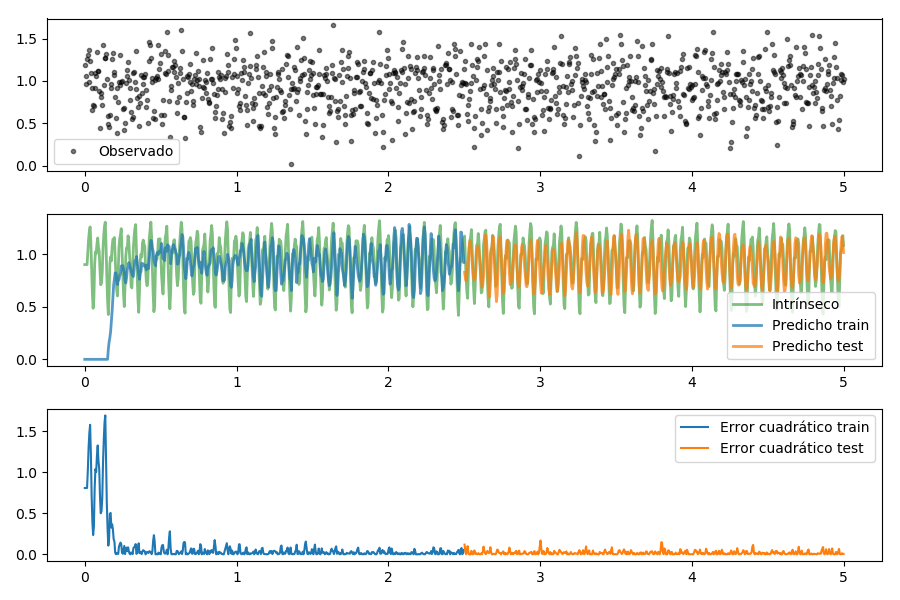

In [6]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intr√≠nseco'); 
ax[1].plot(t[:500], experimentos["optimo"][:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], experimentos["optimo"][500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - experimentos["optimo"][:500])**2, label='Error cuadr√°tico train'); 
ax[2].plot(t[500:], (ymg[500:] - experimentos["optimo"][500:])**2, label='Error cuadr√°tico test'); ax[2].legend(); 

## La prueba media con ùúá‚âà0.298 y L=10

<IPython.core.display.Javascript object>


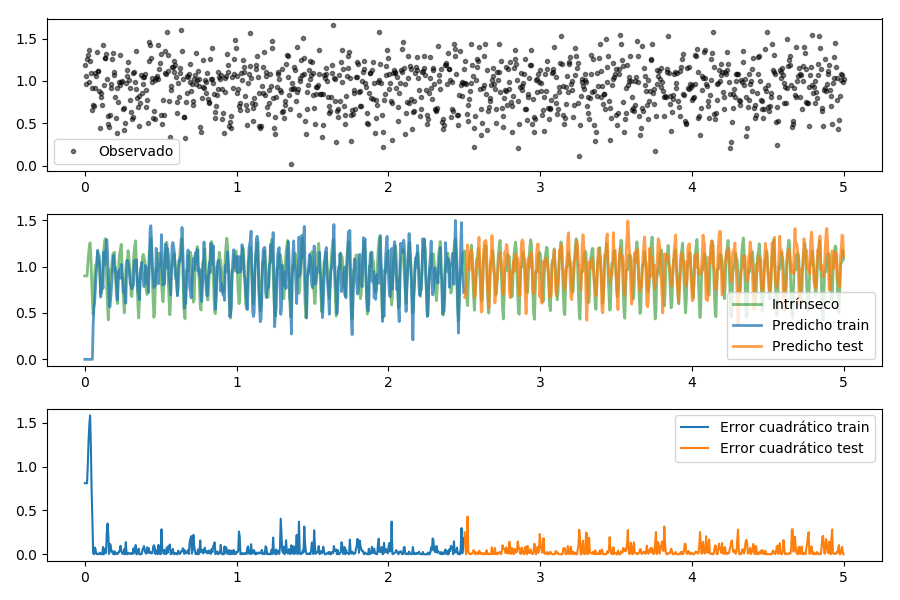

In [7]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intr√≠nseco'); 
ax[1].plot(t[:500], experimentos["media"][:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], experimentos["media"][500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - experimentos["media"][:500])**2, label='Error cuadr√°tico train'); 
ax[2].plot(t[500:], (ymg[500:] - experimentos["media"][500:])**2, label='Error cuadr√°tico test'); ax[2].legend(); 

## La prueba mas inestable con ùúá=1 y L=5

<IPython.core.display.Javascript object>


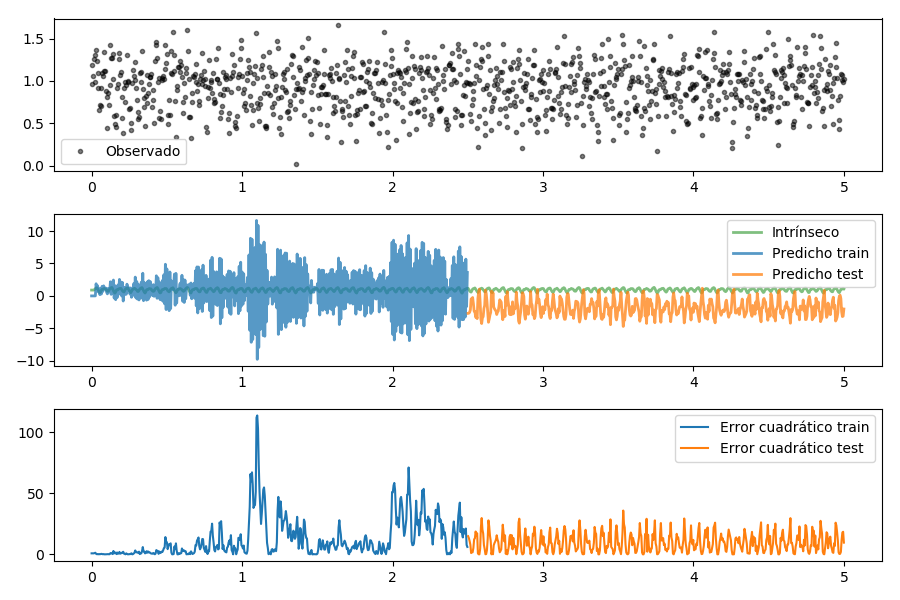

In [8]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intr√≠nseco'); 
ax[1].plot(t[:500], experimentos["inestable"][:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], experimentos["inestable"][500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - experimentos["inestable"][:500])**2, label='Error cuadr√°tico train'); 
ax[2].plot(t[500:], (ymg[500:] - experimentos["inestable"][500:])**2, label='Error cuadr√°tico test'); ax[2].legend(); 

## Conclusiones Cualitativas
Con los datos obtenido podemos ver que en el caso √≥ptimo no existe casi sobreajuste, se demora un poco mas de la media en ajustarse (‚âà 0.21 [seg]) pero una vez pasado ese tiempo, el error es m√≠nimo.

Como podemos ver en el caso elegido de forma aleatoriamente como media, es muy r√°pido en ajustarse (‚âà 0.06 [seg]) pero su error a lo largo del tiempo es mayor que el √≥ptimo. La media tambi√©n se sobreajusta un poco mas que la √≥ptima.

En ning√∫n casi ni en el optimo ni en la media se desestabiliza.

Pero en los datos obtenidas cuantitativamente se pudo distinguir ùúá=1 el cual es completamente inestable, al no ser capaz de obtener nada de √©l e incluso empeorando el ruido.


***
## Predicci√≥n con algoritmo RLS

1. Describa en detalle el algoritmo RLS indicando sus semejanzas y diferencias con el algoritmo LMS
1. Partiendo del error hist√≥rico $J_N(\textbf{w}) = \sum_{i=1}^N \beta^{N-i} e_i^2$ derive la regla recursiva de actualizaci√≥n de pesos 
1. La siguiente clase de *Python* predice y entrena un filtro RLS. Complete las l√≠neas que dice 

` self.w = ? ` y `self.Phi_inv = ?`

con el valor correcto de actualizaci√≥n de peso del filtro RLS

## Respuestas

### 1.

### El algoritmo RLS se base en el algoritmo mencionado anteriormente LMS, pero ocupando caracteristicas online o acumulativas / recursivas, que permiten que el algoritmo se adapte mas r√°pido, lo que implica una convergencia m√°s r√°pida del algoritmo.

### Ventajas RLS sobre LMS: La ventaja es que converge mas r√°pido

### Desventajas RLS sobre LMS: Mayor complejidad computacional (O(L¬≤) > O(L))


### 2.

### XD

### 3.


$$
\begin{align}
\textbf{w}_n = \textbf{w}_{n-1} + \textbf{k}_n e_n 
\end{align}
$$

$$
\begin{align}
\Phi_{n}^{-1} = \beta^{-1} \Phi_{n-1}^{-1} - \beta^{-1} \textbf{k}_n \textbf{u}_n^T \Phi_{n-1}^{-1}
\end{align}
$$

In [9]:
class RLS_filter(object):
    
    def __init__(self, L=1, beta=0.9, delta=10.):
        self.L = L
        self.beta = beta
        self.w = np.zeros(shape=(L, ))
        self.Phi_inv = delta*np.eye(L)
    
    def __len__(self):
        return self.L
    
    def predict(self, u):
        return np.dot(self.w, u)
    
    def update(self, u, d):          
        invbeta = 1.0/self.beta
        d_pred = self.predict(u)
        e = d - d_pred
        r = 1. + invbeta*np.dot(np.dot(u, self.Phi_inv), u.T)
        k = invbeta*np.dot(self.Phi_inv, u)/r       
        self.Phi_inv = invbeta*self.Phi_inv - invbeta*k*d_pred*self.Phi_inv
        self.w = self.w + k*e
        

***

1. Entrene el predictor con el algoritmo RLS usando el siguiente bloque de c√≥digo
1. Considere primero  $\tau=17$
1. Construya una tabla con los NMSE de entrenamiento y prueba para distintos valores de $\beta$ y $L$
    - Se recomienda hacer un barrido lineal en $\beta$ (por ejemplo `mu=np.linspace(0.8, 1.0, num=20)`)
    - Use al menos los siguientes valores de $L$: [5, 10, 20, 30]
1. Describa cada experimento analizando sus resultados de forma cuantitativa y cualitativa
    - ¬øCu√°nto demora el filtro en estabilizarse? 
    - ¬øSe sobreajuste el filtro a los datos de entrenamiento? 
    - ¬øSe desestabiliza el filtro?
1. Indique que combinaci√≥n obtiene menor MSE de prueba 
1. Repita el experimento para $\tau=30$
1. Compare con los resultados obtenidos con el algoritmo LMS ¬øQu√© algoritmo demora menos en converger?


### 1. y 2.

In [10]:
rls = RLS_filter(L=30, beta=0.9, delta=1.)
# Entrenamiento
y_pred = np.zeros(shape=(len(y_obs), ))
for k in range(rls.__len__(), 500):
    y_window = y_obs[k-rls.__len__():k]
    rls.update(d=y_obs[k], u=y_window)
    y_pred[k] = rls.predict(y_window)
# Prueba
for k in range(500, len(y_obs)):
    y_window = y_obs[k-rls.__len__():k]
    y_pred[k] = rls.predict(y_window)
    
print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[rls.__len__():500], y_pred[rls.__len__():500]), 
                                                NMSE(ymg[500:], y_pred[500:])))

MSE entrenamiento 226.1382, prueba 345.8687


### 3.

In [11]:
beta = np.linspace(0.8, 1.0, num=20)
#print(beta)
L = [5, 10, 20, 30]

tabla_2 = np.zeros((len(beta), len(L)*2))
#print(tabla)
experimentos_2 = {
    "optimo": [],
    "media": [],
    "inestable": []
}

optimo_beta = -1
optimo_l = -1
optimo_num = 9999999

peor_beta = -1
peor_l = -1
peor_num = -1

cont_beta = 0
for i in beta:
    cont_columna = 0
    
    cont_l = 0
    for j in L:
        rls = RLS_filter(L=j, beta=i)
        # Entrenamiento
        y_pred = np.zeros(shape=(len(y_obs), ))
        for k in range(rls.__len__(), 500):
            y_window = y_obs[k-rls.__len__():k]
            y_pred[k] = rls.predict(y_window)
            rls.update(d=y_obs[k], u=y_window)
        # Prueba
        for k in range(500, len(y_obs)):
            y_window = y_obs[k-rls.__len__():k]
            y_pred[k] = rls.predict(y_window)
        ## Optimo
        if (cont_beta == 19 and cont_l == 2):
            experimentos_2["optimo"] = y_pred
        elif (cont_beta == 0 and cont_l == 0): ## Inestable
            experimentos_2["inestable"] = y_pred
        elif (cont_beta == 7 and cont_l == 2): ## Media
            experimentos_2["media"] = y_pred
            
            
        entrenamiento = NMSE(ymg[rls.__len__():500], y_pred[rls.__len__():500])
        prueba = NMSE(ymg[500:], y_pred[500:])
        if (prueba < optimo_num):
            optimo_beta = cont_beta
            optimo_l = cont_l
            optimo_num = prueba
        if (prueba > peor_num):
            peor_beta = cont_beta
            peor_l = cont_l
            peor_num = prueba
        tabla_2[cont_beta][cont_columna] = np.format_float_scientific(entrenamiento, 7)
        tabla_2[cont_beta][cont_columna+1] = np.format_float_scientific(prueba, 7)
        #print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[lms.__len__():500], y_pred[lms.__len__():500]), 
        #                                                NMSE(ymg[500:], y_pred[500:])))
        cont_l += 1
        cont_columna += 2
    cont_beta += 1

print("El beta optimo es: " + str(beta[optimo_beta]) + ", junto con el L optimo: " + str(L[optimo_l]) + ", con MSE de prueba: " + str(optimo_num))
print("El beta peor es: " + str(beta[peor_beta]) + ", junto con el L peor: " + str(L[peor_l]) + ", con MSE de prueba: " + str(peor_num))
print("El beta media es: " + str(beta[7]) + ", junto con el L media: " + str(L[2]) + ", con MSE de prueba: " + str(tabla_2[7][5]))

El beta optimo es: 1.0, junto con el L optimo: 20, con MSE de prueba: 214.03582058041417
El beta peor es: 0.8, junto con el L peor: 5, con MSE de prueba: 1223.3335127245598
El beta media es: 0.8736842105263158, junto con el L media: 20, con MSE de prueba: 476.28962


In [12]:
pd.DataFrame(tabla_2, columns=["5_entrenamiento","5_prueba", "10_entrenamiento", "10_prueba", "20_entrenamiento", "20_prueba", "30_entrenamiento", "30_prueba"])

5_entrenamiento    5_prueba  10_entrenamiento   10_prueba  \
0         994.20709  1223.33350         487.85819  1101.03940   
1         978.86941  1130.25680         487.85000  1101.03630   
2         958.08595  1033.87770         487.83998  1101.03240   
3         936.52890   946.28512         487.82747  1101.02750   
4         914.65772   867.91568         487.81131  1101.02080   
5         892.69012   799.57147         487.78941  1101.01130   
6         870.73595   741.50416         487.75748  1100.99680   
7         848.82680   693.29775         487.70568  1100.97270   
8         826.96665   653.87550         487.60715  1100.92640   
9         805.16296   621.60080         487.36061  1100.75390   
10        783.45200   594.48053         486.21754  1093.23960   
11        761.93272   570.46637         477.61107   911.32173   
12        740.81316   547.82869         458.48318   679.94921   
13        720.46838   525.57519         436.83296   520.52327   
14        701.50993   503.92719         414.87679   412.42257   
15        684.87573   484.94483         393.11396   346.58112   
16        671.99218   473.42739         372.37979   314.51827   
17        665.22721   478.21192         353.90785   307.01224   
18        669.15228   514.74291         339.15322   306.57191   
19        689.70574   597.59732         330.46766   310.64921   

    20_entrenamiento  20_prueba  30_entrenamiento  30_prueba  
0          351.03974  476.32724         322.83193  346.01555  
1          351.03913  476.32381         322.83145  346.01486  
2          351.03845  476.31996         322.83090  346.01403  
3          351.03767  476.31561         322.83025  346.01304  
4          351.03674  476.31063         322.82946  346.01186  
5          351.03558  476.30485         322.82852  346.01041  
6          351.03407  476.29799         322.82735  346.00863  
7          351.03203  476.28962         322.82589  346.00638  
8          351.02912  476.27902         322.82402  346.00349  
9          351.02477  476.26482         322.82154  345.99964  
10         351.01788  476.24432         322.81814  345.99429  
11         351.00616  476.21156         322.81321  345.98644  
12         350.98415  476.15119         322.80564  345.97414  
13         350.93507  476.00726         322.79298  345.95303  
14         350.76685  475.36880         322.76893  345.91089  
15         348.99488  470.55264         322.70842  345.78830  
16         336.12791  441.00136         322.34266  344.88879  
17         319.36912  375.08936         315.65041  337.53164  
18         307.37883  303.99898         296.80860  315.59023  
19         298.71681  214.03582         285.19777  219.97242

## 4.

## La prueba optima con Œ≤=1.0 y L=30

<IPython.core.display.Javascript object>


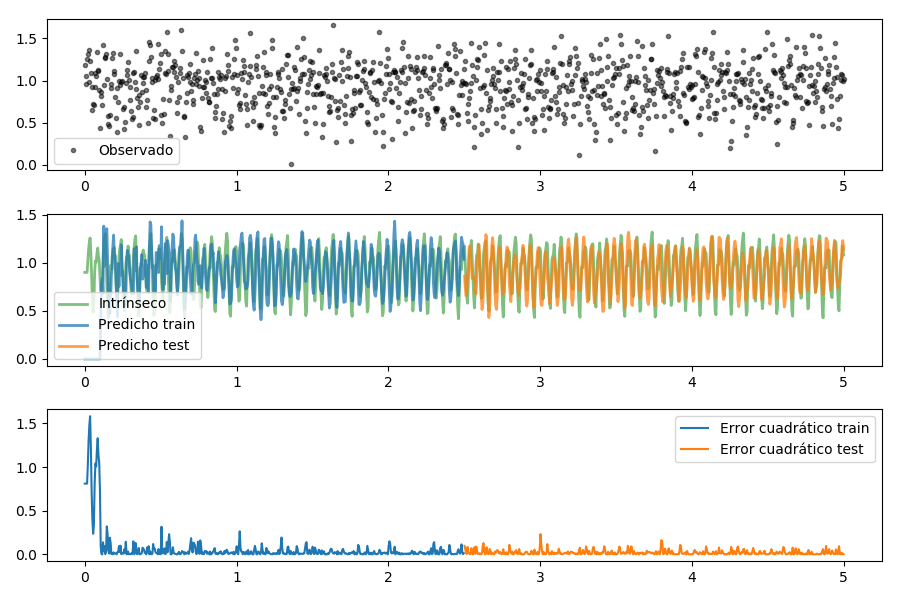

In [13]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intr√≠nseco'); 
ax[1].plot(t[:500], experimentos_2["optimo"][:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], experimentos_2["optimo"][500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - experimentos_2["optimo"][:500])**2, label='Error cuadr√°tico train'); 
ax[2].plot(t[500:], (ymg[500:] - experimentos_2["optimo"][500:])**2, label='Error cuadr√°tico test'); ax[2].legend(); 

## La prueba media con Œ≤‚âà0.874 y L=20

<IPython.core.display.Javascript object>


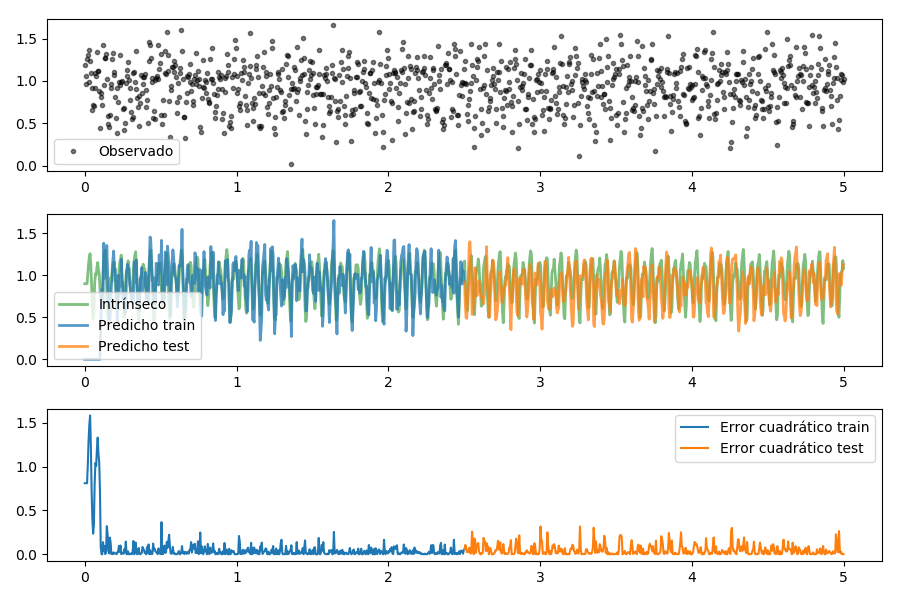

In [14]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intr√≠nseco'); 
ax[1].plot(t[:500], experimentos_2["media"][:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], experimentos_2["media"][500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - experimentos_2["media"][:500])**2, label='Error cuadr√°tico train'); 
ax[2].plot(t[500:], (ymg[500:] - experimentos_2["media"][500:])**2, label='Error cuadr√°tico test'); ax[2].legend(); 

## La prueba mas inestable con Œ≤=0.8 y L=5

<IPython.core.display.Javascript object>


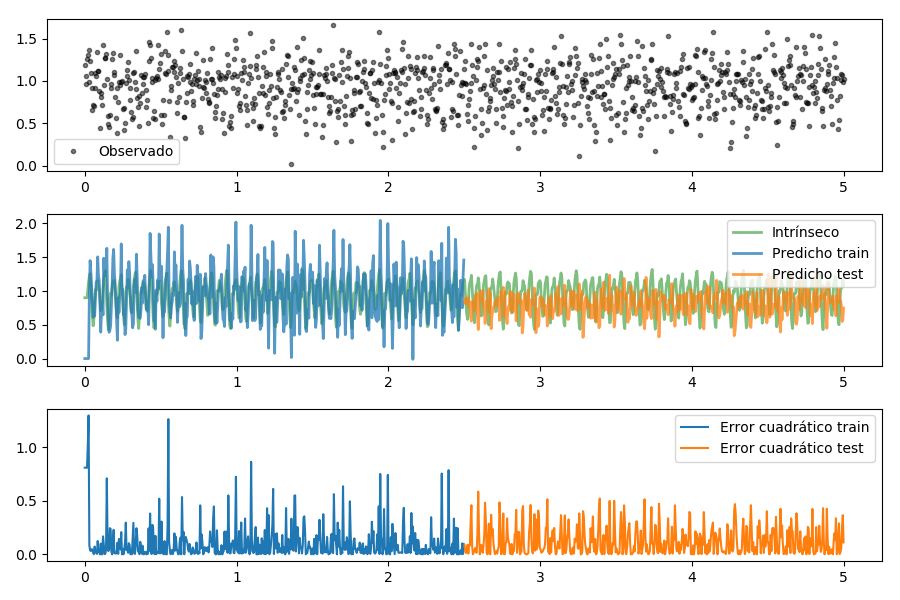

In [15]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intr√≠nseco'); 
ax[1].plot(t[:500], experimentos_2["inestable"][:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], experimentos_2["inestable"][500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - experimentos_2["inestable"][:500])**2, label='Error cuadr√°tico train'); 
ax[2].plot(t[500:], (ymg[500:] - experimentos_2["inestable"][500:])**2, label='Error cuadr√°tico test'); ax[2].legend(); 

## Conclusiones Cualitativas

Con los datos obtenido podemos ver que en el caso √≥ptimo no existe casi sobreajuste y se demora casi lo mismo que la media en ajustarse (‚âà 0.10 [seg]) y su error en general es muy bajo luego del ajuste.

Como podemos ver en el caso elegido de forma aleatoriamente como media, es muy r√°pido en ajustarse al igual que en el caso √≥ptimo (‚âà 0.10 [seg]) pero su error a lo largo del tiempo es considerablemente mayor que el √≥ptimo. Y tambi√©n se sobreajusta un poco mas que la √≥ptima pero de forma muy moderada.

En los datos obtenidos no hubo ninguno que se haya disparado como lo fue en el caso anterior, simplemente llegamos a un peor objetivamente hablando en el que se puede observar que se demora muy poco en "estabilizarse" (siesque se le puede clasificar as√≠) (‚âà 0.04 [seg]), pero el error obtenido en promedio es mucho mayor que en los 2 casos anteriores, y existe un sobreajuste muy considerable del filtro con respecto a los datos de entrenamiento.


## 5.

### La combinaci√≥n que obtiene el mejor MSE de prueba es:  Œ≤=1.0 y L=30 con un MSE ‚âà 214.04

## 6.

<IPython.core.display.Javascript object>


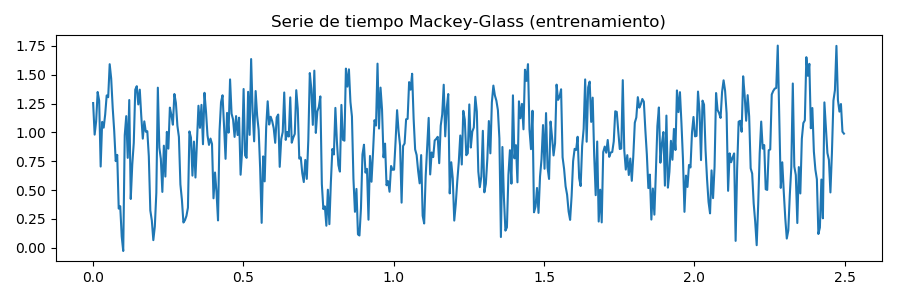

In [37]:
# n√∫mero de observaciones (no modificar)
N = 1000
# Raz√≥n se√±al a ruido (2., 0.5)
SNR = 2.
# constantes de la ecuaci√≥n diferencial (no modificar)
a, b = 0.1, 0.2
# comportamiento din√°mico de Mackey-Glass (17, 30)
tau = 30.
# paso de integraci√≥n (no modificar)
dt = 0.05
# condici√≥n incial (no modificar)
y0 = 0.9
# largo temporal (no modificar)
tt = 5.
t = np.linspace(0, tt, num=N)

N_full, tau_full = int(N*tt/dt), int(tau/dt)
ymg = y0*np.ones(shape=(N_full, ))
# Runge-Kutta integration
for n in range(tau_full, N_full-1):
    byd = b*ymg[n-tau_full]/(1.0 + ymg[n-tau_full]**10.0)
    yk1 = dt*(-a*ymg[n] + byd)
    yk2 = dt*(-a*(ymg[n]+yk1/2) + byd)
    yk3 = dt*(-a*(ymg[n]+yk2/2) + byd)
    yk4 = dt*(-a*(ymg[n]+yk3) + byd)
    ymg[n+1] = ymg[n] + yk1/6 + yk2/3 +yk3/3 +yk4/6;
ymg = ymg[::int(tt/dt)]
#ymg = ymg - np.mean(ymg) 
# Contaminaci√≥n con ruido blanco aditivo
s_noise = np.sqrt(np.var(ymg)/SNR) 
np.random.seed(0)
y_obs = ymg + s_noise*np.random.randn(len(ymg))
# Gr√°fico
fig, ax = plt.subplots(1, figsize=(9, 3), tight_layout=True)
ax.plot(t[:500], y_obs[:500])
ax.set_title('Serie de tiempo Mackey-Glass (entrenamiento)');

<IPython.core.display.Javascript object>


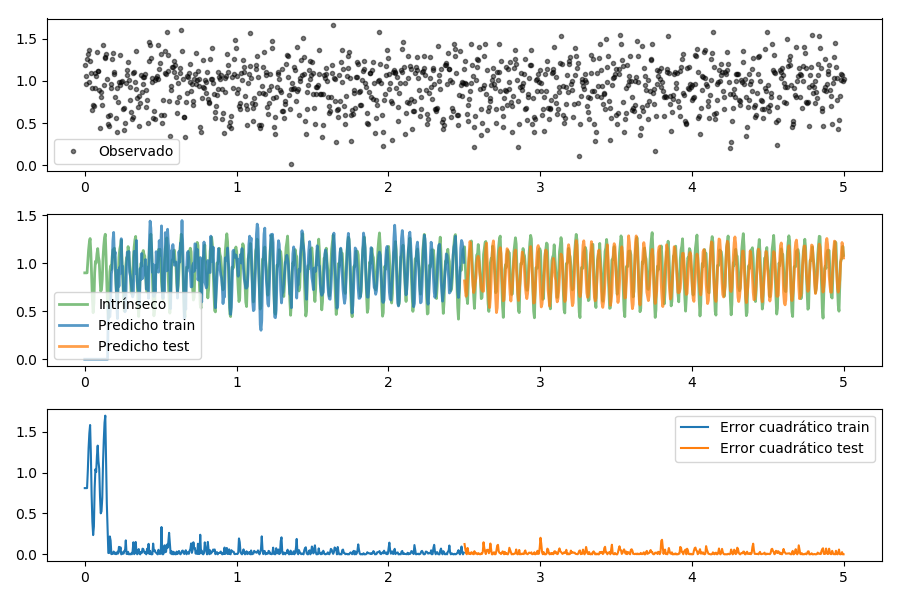

In [16]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intr√≠nseco'); 
ax[1].plot(t[:500], y_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], y_pred[500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - y_pred[:500])**2, label='Error cuadr√°tico train'); 
ax[2].plot(t[500:], (ymg[500:] - y_pred[500:])**2, label='Error cuadr√°tico test'); ax[2].legend(); 

NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)